Epoch 1/50 - Loss: 81.6118 - Train Acc: 0.5000 - Val Acc: 0.5000 - Test Acc: 0.4986
Epoch 2/50 - Loss: 74.7865 - Train Acc: 0.5454 - Val Acc: 0.5000 - Test Acc: 0.5144
Epoch 3/50 - Loss: 74.6587 - Train Acc: 0.5402 - Val Acc: 0.5073 - Test Acc: 0.5230
Epoch 4/50 - Loss: 74.5074 - Train Acc: 0.5279 - Val Acc: 0.4869 - Test Acc: 0.5043
Epoch 5/50 - Loss: 74.3476 - Train Acc: 0.5314 - Val Acc: 0.4782 - Test Acc: 0.5029
Epoch 6/50 - Loss: 74.3358 - Train Acc: 0.5728 - Val Acc: 0.5015 - Test Acc: 0.5316
Epoch 7/50 - Loss: 73.8355 - Train Acc: 0.5827 - Val Acc: 0.4942 - Test Acc: 0.5431
Epoch 8/50 - Loss: 73.7382 - Train Acc: 0.5858 - Val Acc: 0.4985 - Test Acc: 0.5359
Epoch 9/50 - Loss: 73.8800 - Train Acc: 0.5834 - Val Acc: 0.4884 - Test Acc: 0.5244
Epoch 10/50 - Loss: 74.0139 - Train Acc: 0.5937 - Val Acc: 0.5131 - Test Acc: 0.4986
Epoch 11/50 - Loss: 73.2131 - Train Acc: 0.5815 - Val Acc: 0.4942 - Test Acc: 0.4885
Epoch 12/50 - Loss: 73.6033 - Train Acc: 0.5943 - Val Acc: 0.5073 - Test A

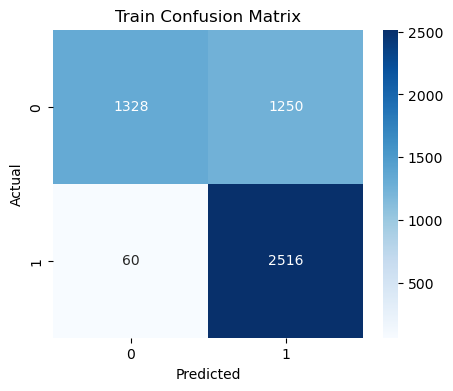

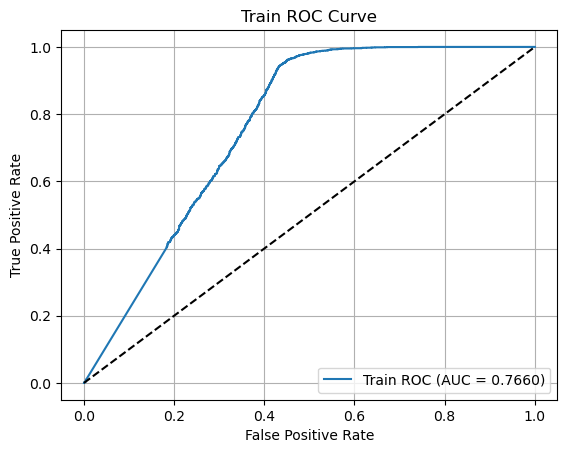


--- Test Set Evaluation ---
Accuracy:  0.5144
Precision: 0.5087
Recall:    0.7608
F1-score:  0.6097
AUC-ROC:   0.5308

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.27      0.36       349
           1       0.51      0.76      0.61       347

    accuracy                           0.51       696
   macro avg       0.52      0.52      0.48       696
weighted avg       0.52      0.51      0.48       696



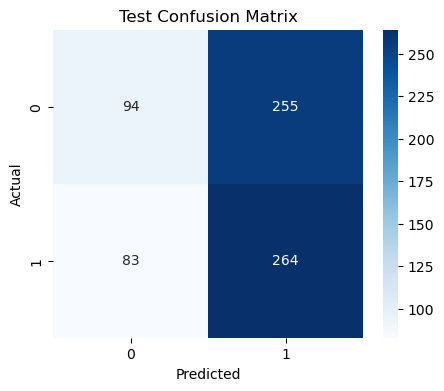

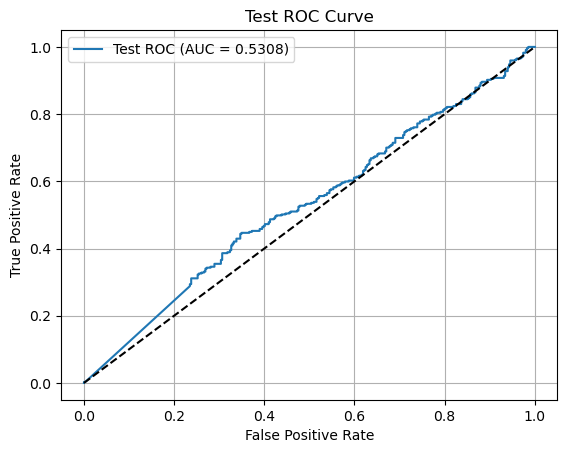

In [1]:
# CNN with processed_data3
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIGURATION ===
data_dir = '/storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/processed_data3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 50
batch_size = 64

# === Load File List and Labels ===
npz_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npz')])

all_labels = []
for file in npz_files:
    y = np.load(file)['y']
    all_labels.extend(y)
all_labels = np.array(all_labels)

classes = np.unique(all_labels)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=all_labels)
class_weights_tensor = torch.tensor(class_weights_array, dtype=torch.float32).to(device)

# === Train-Test Split ===
train_files, test_files = train_test_split(npz_files, test_size=0.2, random_state=42, shuffle=True)
val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

# === Fit Scaler on Sample Training Data ===
scaler = StandardScaler()
sample_data = []
for file in train_files[:5]:
    X = np.load(file)['X']
    X = X.reshape(X.shape[0], -1)
    sample_data.append(X)
scaler.fit(np.vstack(sample_data))

# === CNN Model for EEG Data ===
class EEG_CNN(nn.Module):
    def __init__(self, input_channels, seq_len, num_classes):
        super(EEG_CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3),

            nn.Flatten(),
            nn.Linear((seq_len // 4) * 64, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# === Prepare Sample Input ===
sample_X = np.load(train_files[0])['X']
sample_X = scaler.transform(sample_X.reshape(sample_X.shape[0], -1))
num_channels = sample_X.shape[1]
time_steps = 1  # Fake dimension for Conv1d if you use flat inputs

# Try reshaping back to original dimensions
X_shape = np.load(train_files[0])['X'].shape  # (n_samples, channels, time)
input_channels = X_shape[1]
seq_len = X_shape[2]

model = EEG_CNN(input_channels, seq_len, len(classes)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# === Accuracy Function ===
def get_accuracy(files):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for file in files:
            data = np.load(file)
            X, y = data['X'], data['y']
            X = X.astype(np.float32)
            n, c, t = X.shape
            X = X.reshape(n, -1)
            X = scaler.transform(X)
            X = X.reshape(n, c, t)

            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y, dtype=torch.long).to(device)

            outputs = model(X_tensor)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == y_tensor).sum().item()
            total += y_tensor.size(0)
    return correct / total

# === Evaluation Function ===
def evaluate_model(files, set_name="Test"):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for file in files:
            data = np.load(file)
            X, y = data['X'], data['y']
            X = X.astype(np.float32)
            n, c, t = X.shape
            X = X.reshape(n, -1)
            X = scaler.transform(X)
            X = X.reshape(n, c, t)

            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            outputs = model(X_tensor)
            probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()

            y_true.extend(y)
            y_pred.extend(predictions)
            y_prob.extend(probabilities)

    print(f"\n--- {set_name} Set Evaluation ---")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_true, y_pred):.4f}")
    print(f"AUC-ROC:   {roc_auc_score(y_true, y_prob):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{set_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{set_name} ROC (AUC = {roc_auc_score(y_true, y_prob):.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{set_name} ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# === Training Loop ===
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for file in train_files:
        data = np.load(file)
        X, y = data['X'], data['y']
        X = X.astype(np.float32)
        n, c, t = X.shape
        X = X.reshape(n, -1)
        X = scaler.transform(X)
        X = X.reshape(n, c, t)

        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(device)

        for start in range(0, len(X_tensor), batch_size):
            end = start + batch_size
            X_batch = X_tensor[start:end]
            y_batch = y_tensor[start:end]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

    train_acc = get_accuracy(train_files)
    val_acc = get_accuracy(val_files)
    test_acc = get_accuracy(test_files)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f} - Test Acc: {test_acc:.4f}")

# === Final Evaluation ===
evaluate_model(train_files, set_name="Train")
evaluate_model(test_files, set_name="Test")
